In [16]:
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
#from sklearn import pipeline, model_selection
from sklearn import pipeline, grid_search
#from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer

import re

import random
random.seed(2016)
pd.set_option("display.max_colwidth", 200)

%matplotlib inline

import matplotlib

# LOC = '/home/ec2-user/data/hd/unpacked/'
# df_train = pd.read_csv(LOC + 'train.csv', encoding="ISO-8859-1")
# num_train = df_train.shape[0]

In [ ]:
dtrain = xgb.DMatrix("train.buffer")
dtest = xgb.DMatrix("test.buffer")
evallist  = [(dtrain,'train')]

In [ ]:
a = np.load('train_data.npy')
b = np.load('test_data.npy')
a_brand = np.load('features_brand_01_train.npy')
b_brand = np.load('features_brand_01_test.npy')
a = np.hstack((a, a_brand))
b = np.hstack((b, b_brand))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(a, dtrain.get_label(), test_size=0.20, random_state=147)
gX_train = xgb.DMatrix(data=X_train, label=y_train)
gX_test = xgb.DMatrix(data=X_test, label=y_test)
evallist  = [(gX_train,'train'),(gX_test,'test')]

In [ ]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

In [ ]:
#clf = linear_model.LinearRegression(n_jobs=8)
clf = linear_model.Ridge (alpha = .6)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)
fmean_squared_error(y_hat, y_test)

In [ ]:
clf = linear_model.Ridge (alpha = .6)
clf.fit(a, dtrain.get_label())
y_hat = clf.predict(X_test)
y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)


In [ ]:
xgb.train?

In [ ]:
# TRAIN AS SELF
param = {'max_depth':9, 
         'eta':0.1, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.3,
         'subsample':0.9,
         'nthread':8,
         'silent': True
        }
num_round = 5000
bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], early_stopping_rounds=15, verbose_eval=10)

In [ ]:
#7	0.05	0.8	0.9	500		0.452797
#13	0.01	0.3	0.9
param = {'max_depth':13, 
         'eta':0.01, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.3,
         'subsample':0.9,
         'nthread':8,
         'silent': True
        }
num_round = 5000
bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], early_stopping_rounds=15, verbose_eval=10)

In [ ]:
num_round = 800

#bst = xgb.train( param, dtrain, num_round, [(gX_train,'train'),(gX_test,'test')], verbose_eval=20)
bst = xgb.train( param, dtrain, num_round, [(gX_test,'test')], verbose_eval=20)

#LOC = '/home/ec2-user/data/hd/unpacked/'
LOC = '/Users/rbekbolatov/data/kaggle/homedepot/'
df_test = pd.read_csv(LOC + 'test.csv', encoding="ISO-8859-1")
id_test = df_test['id']

y_pred = bst.predict(dtest, ntree_limit=500)
y_pred_bounded = np.minimum(np.maximum(y_pred, 1.0), 3.0)
pd.DataFrame({"id": id_test, "relevance": y_pred_bounded}).to_csv('submission_xgboost_2.csv',index=False)

In [ ]:
##  THIS CREATED HIGHEST SO FAR : 3/25 1:27am (8a)
fmi = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_blend_0403_1631.csv.gz', encoding="ISO-8859-1")
fo = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_xgboost_words_0405_1446.csv.gz', encoding="ISO-8859-1")

In [ ]:
fmi.head()

In [ ]:
fo.head()

In [ ]:
clf = linear_model.Ridge (alpha = .6)
clf.fit(a, dtrain.get_label())
y_hat = clf.predict(b)
y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)

#fmi = pd.DataFrame({"id": fmi['id'], "relevance": y_hat})
fmi['relevance'] = y_hat

In [ ]:
fmi.head()

In [ ]:
fo1 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/frommany/submission_xgboost_cum3_000135.csv.gz', encoding="ISO-8859-1")
fo1.columns = ['id', 'rel1']
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/frommany4/submission_xgboost_cum4_00017.csv.gz', encoding="ISO-8859-1")
fo2.columns = ['id', 'rel2']
fo3 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_xgboost_words_0406_1720.csv.gz', encoding="ISO-8859-1")
fo3.columns = ['id', 'rel3']
fo4 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_blend_0405_1501.csv', encoding="ISO-8859-1")
fo4.columns = ['id', 'rel4']


res = pd.merge(pd.merge(pd.merge(fo1, fo2, how='left', on='id'), fo3, how='left', on='id'), fo4, how='left', on='id')

def f(r):
    #return r['rel1']*0.35 + r['rel2']*0.55 + r['rel3']*0.05 + r['rel4']*0.05
    return r['rel2']*0.80 + r['rel3']*0.20

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('submission_superblend_0406_2050.csv',index=False)

In [ ]:
fo1 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_tf_idf2_45445_apr07.csv', encoding="ISO-8859-1").sort_values(by='id')
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_blend_0406_1742.csv', encoding="ISO-8859-1")

In [ ]:
fo1.head(10)

In [ ]:
fo2.head(10)

In [1]:
fo1 = pd.read_csv('~/Downloads/ens3_top10_by_id_modified.csv', encoding="ISO-8859-1")

In [5]:
fo1.tail()

,id,relevance
166688,240756,1.0
166689,240757,1.0
166690,240758,1.0
166691,240759,1.0
166692,240760,1.0


In [18]:
166692*0.5

83346.0

In [21]:
fo1.to_csv('bottom50.csv',index=False)

In [23]:
fo1.iloc[83345]

id           124002.0
relevance         1.0
Name: 83345, dtype: float64

In [17]:
fo1.iloc[150021]


id           224089.000000
relevance         2.263122
Name: 150021, dtype: float64

In [19]:
fo1.iloc[0:83346]['relevance'] =  1.0

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
fo1

,id,relevance
0,1,1.0
1,4,1.0
2,5,1.0
3,6,1.0
4,7,1.0
5,8,1.0
6,10,1.0
7,11,1.0
8,12,1.0
9,13,1.0


In [ ]:
fo1 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_team_superblend_0407_2233.csv', encoding="ISO-8859-1")
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_RenatPawel_combined_features_xgboost_0408_0137.csv.gz', encoding="ISO-8859-1")

res = pd.merge(fo1, fo2, how='left', on='id')

def f(r):
    return r['relevance_x']*0.80 + r['relevance_y']*0.20

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('submission_team_superblend_0408_1728.csv',index=False)

In [ ]:
fo1 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_team_superblend_0408_0155.csv', encoding="ISO-8859-1")
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_RenatPawel_combined_features_extratrees_AVG_0408_1708.csv', encoding="ISO-8859-1")

res = pd.merge(fo1, fo2, how='left', on='id')

def f(r):
    return r['relevance_x']*0.90 + r['relevance_y']*0.10

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('submission_team_superblend_xg_xt_0408_1730.csv',index=False)

In [ ]:
fo1 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_RenatPawel_combined_features_extratrees_0408_1705.csv.gz', encoding="ISO-8859-1")
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_RenatPawel_combined_features_extratrees_0408_1631.csv.gz', encoding="ISO-8859-1")

res = pd.merge(fo1, fo2, how='left', on='id')

def f(r):
    return r['relevance_x']*0.55 + r['relevance_y']*0.45

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('submission_RenatPawel_combined_features_extratrees_AVG_0408_1708.csv',index=False)

In [7]:
#ens0904*0.8 + submission_team_superblend_0408_0155*0.2
fo1 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/slippery_appraisals_ens0904.csv', encoding="ISO-8859-1")
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_team_superblend_0408_0155.csv', encoding="ISO-8859-1")

res = pd.merge(fo1, fo2, how='left', on='id')

def f(r):
    return r['relevance_x']*0.80 + r['relevance_y']*0.20

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('submission_slippery_blend_0409_2220.csv',index=False)

In [11]:
## 
# 0.7x stack10_submit_10 + 0.3x ens_Apr20_2
fo1 = pd.read_csv('/Users/rbekbolatov/Downloads/stack10_submit_10.csv', encoding="ISO-8859-1")
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/xgb_submission_Apr23_xgb3.csv.gz', encoding="ISO-8859-1")

res = pd.merge(fo1, fo2, how='left', on='id')

def f(r):
    return r['relevance_x']*0.85 + r['relevance_y']*0.15

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('ens_Apr23_1.csv',index=False)

In [13]:
##  STACKED + XGB + ET 
# 0.85x stack10_submit_12 + 0.15x (avg: XGBx30 + ETx10)
fo1 = pd.read_csv('/Users/rbekbolatov/Downloads/stack10_submit_12.csv', encoding="ISO-8859-1")
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/combined_xgb_et.csv', encoding="ISO-8859-1")

res = pd.merge(fo1, fo2, how='left', on='id')

def f(r):
    return r['relevance_x']*0.85 + r['relevance_y']*0.15

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('ens_Apr24_1.csv',index=False)

IOError: File /Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/combined_xgb_et.csv does not exist

In [35]:
##  STACKED + ens_Apr23_1 + (XGB + ET)
# 0.9*0.96x stack10_submit_12 + 0.1*0.96x ens_Apr23_1.csv + 0.04x (avg: 0.9xXGBx30 + 0.1xETx10)
fo1 = pd.read_csv('/Users/rbekbolatov/Downloads/stack10_submit_12.csv', encoding="ISO-8859-1")
fo1.columns = ['id', 'rel1']
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/ens_Apr23_1.csv', encoding="ISO-8859-1")
fo2.columns = ['id', 'rel2']
fo3 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/combined_xgb_et.csv', encoding="ISO-8859-1")
fo3.columns = ['id', 'rel3']

res = pd.merge(pd.merge(fo1, fo2, how='left', on='id'), fo3, how='left', on='id')

def f(r):
    return r['rel1']*0.9*0.96 + r['rel2']*0.1*0.96 + r['rel3']*0.04

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('ens_Apr24_1.csv',index=False)

In [30]:
fo1.head()

,id,rel1
0,1,2.008464
1,4,2.128645
2,5,2.320847
3,6,2.766010
4,7,2.400800


In [31]:
fo2.head()

,id,rel2
0,1,2.008898
1,4,2.122168
2,5,2.316514
3,6,2.774981
4,7,2.397351


In [34]:
fo3.head()

,id,rel3
0,1,2.031228
1,4,2.122132
2,5,2.322573
3,6,2.757399
4,7,2.434674


In [ ]:
%precision 3
bi,bj,bc = -1, -1, 1.1
for i,e in enumerate(els):
    a = []
    for j,f in enumerate(els):
        pp = pearsonr(e['relevance'], f['relevance'])[0]
        if pp < bc:
            bc = pp
            bi = i
            bj = j
        a.append('%0.3f' % pp)
    print ' '.join(a)
print bi,bj,bc

In [12]:
## 
# 0.7x stack10_submit_10 + 0.3x ens_Apr20_2
fo1 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/ens_Apr23_1.csv', encoding="ISO-8859-1")
fo2 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/lr_stack_batch10.csv', encoding="ISO-8859-1")

res = pd.merge(fo1, fo2, how='left', on='id')

def f(r):
    return r['relevance_x']*0.5 + r['relevance_y']*0.5

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('ens_with_lr_stack_Apr23_1.csv',index=False)

In [13]:
# xgb_alldatRenPawW2vN*0.37 + 160412_ID25_Pawel_Renal_XGB_Zach_new_R*0.34 + submission_team_superblend_0408_0155*0.29
fo1 = pd.read_csv('/Users/rbekbolatov/Downloads/xgb_alldatRenPawW2vN.csv', encoding="ISO-8859-1")
fo1.columns = ['id', 'rel1']
fo2 = pd.read_csv('/Users/rbekbolatov/Downloads/160412_ID25_Pawel_Renal_XGB_Zach_new_R.csv', encoding="ISO-8859-1")
fo2.columns = ['id', 'rel2']
fo3 = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_team_superblend_0408_0155.csv', encoding="ISO-8859-1")
fo3.columns = ['id', 'rel3']

res = pd.merge(pd.merge(fo1, fo2, how='left', on='id'), fo3, how='left', on='id')

def f(r):
    return r['rel1']*0.37 + r['rel2']*0.34 + r['rel3']*0.29

y_pred = res.apply(f, axis=1)
pd.DataFrame({"id": res['id'], "relevance": y_pred}).to_csv('ens_Apr13_2.csv',index=False)

In [6]:
fo2.head(3)

,id,relevance
0,1,2.040897
1,4,2.080843
2,5,2.497565


In [ ]:
fmir = pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_team_superblend_0407_2152.csv', encoding="ISO-8859-1")

In [ ]:
fmir.head(10)

In [ ]:
#from scipy.stats import pearsonr
pearsonr?

In [ ]:
els = [
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_tf_idf2_45445_apr07.csv', encoding="ISO-8859-1").sort_values(by='id'),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_tf_idf2_45456_apr04.csv', encoding="ISO-8859-1").sort_values(by='id'),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_tf_idf2_45469_apr07.csv', encoding="ISO-8859-1").sort_values(by='id'),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_tf_idf2_45476_apr07.csv', encoding="ISO-8859-1").sort_values(by='id'),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_tf_idf2_45503_apr04.csv', encoding="ISO-8859-1").sort_values(by='id'),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_tf_idf2_45544_apr05.csv', encoding="ISO-8859-1").sort_values(by='id'),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_blend_0406_1742.csv', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_superblend_0406_2047.csv', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/frommany/submission_xgboost_cum3_000135.csv.gz', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/frommany/submission_xgboost_cum2_000036.csv.gz', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_blend_0405_1940.csv.gz', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/frommany/submission_xgboost_cum2_000012.csv.gz', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_RenatPawel_combined_features_xgboost_0408_0137.csv.gz', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_team_superblend_0407_2233.csv', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_RenatPawel_xgboost_AVG_00043.csv.gz', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_RenatPawel_xgboost_AVG_00044.csv.gz', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_RenatPawel_combined_features_extratrees_0408_1631.csv.gz', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/submission_team_superblend_0408_0155.csv', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/slippery_appraisals_ens0904.csv', encoding="ISO-8859-1"),    
    ]

In [ ]:
%precision 3
bi,bj,bc = -1, -1, 1.1
for i,e in enumerate(els):
    a = []
    for j,f in enumerate(els):
        pp = pearsonr(e['relevance'], f['relevance'])[0]
        if pp < bc:
            bc = pp
            bi = i
            bj = j
        a.append('%0.3f' % pp)
    print ' '.join(a)
print bi,bj,bc

In [25]:
els = [
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/forstack30xgb/train_forstack_Apr23_xgb10_10.csv', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/forstack30xgb/train_forstack_Apr23_xgb09_10.csv', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/forstack10et/train_forstack_Apr24_et06_10.csv', encoding="ISO-8859-1"),
    pd.read_csv('/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks/forstack10et/train_forstack_Apr24_et10_10.csv', encoding="ISO-8859-1"),
    ]
for x in els:
    x.columns = ['relevance']

In [26]:
%precision 3
bi,bj,bc = -1, -1, 1.1
for i,e in enumerate(els):
    a = []
    for j,f in enumerate(els):
        pp = pearsonr(e['relevance'], f['relevance'])[0]
        if pp < bc:
            bc = pp
            bi = i
            bj = j
        a.append('%0.3f' % pp)
    print ' '.join(a)
print bi,bj,bc

1.000 0.995 0.927 0.927
0.995 1.000 0.927 0.927
0.927 0.927 1.000 0.991
0.927 0.927 0.991 1.000
1 2 0.927009695873


In [ ]:
pearsonr(fo1['relevance'], fo2['relevance'])  #4, #2

In [ ]:
(fmir.relevance > 3).sum()

In [ ]:
print(str((bst.best_iteration, bst.best_ntree_limit)))
xgb.cv(param, dtrain, num_boost_round=10, nfold=2, metrics={'error'}, maximize=False, seed = 0)

In [ ]:
# TRAIN AS SKLEARN
clf = xgb.XGBClassifier(**param_clf)
#clf.get_params().keys()
clf.fit(a, dtrain.get_label())
by = clf.predict(b)

In [ ]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

def fmse(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions)

#RMSE  = make_scorer(fmse, greater_is_better=False)
RMSE  = make_scorer(fmean_squared_error, greater_is_better=False)

In [ ]:
# param_clf = {'max_depth':2, 
#          'learning_rate':0.5, 
#          'colsample_bytree':0.8,
#          'subsample':0.95,
#          'nthread':4,
#          'n_estimators': 120
#         }
paramso = {'max_depth': [3], 
         'learning_rate': [0.1], 
         'colsample_bytree':[1],
         'subsample':[1],
         'n_estimators':[10]
        }
#num_round = 120

In [ ]:
grid_search.GridSearchCV?

In [ ]:
model = grid_search.GridSearchCV(
    estimator = xgb.XGBClassifier(silent=False, nthread=8), #**param_clf), 
    param_grid = paramso, cv = 3, verbose = 20, scoring=RMSE)

In [ ]:
model.fit(a, dtrain.get_label())

print("Best parameters found by grid search:")
print(model.best_params_)
print("Best CV score:")
print(model.best_score_)

In [2]:
loc = '%s'
idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

In [7]:
a

,index,id,relevance
0,0,2,3.00
1,1,3,2.50
2,2,9,3.00
3,3,16,2.33
4,4,17,2.67
5,5,18,3.00
6,6,20,2.67
7,7,21,3.00
8,8,23,2.67
9,9,27,3.00


In [78]:
a = idx_train.reset_index().reset_index()
import math
a[['index', 'relevance']]
a['idx'] = a.apply(lambda r: math.floor(r['index']/500), axis=1)

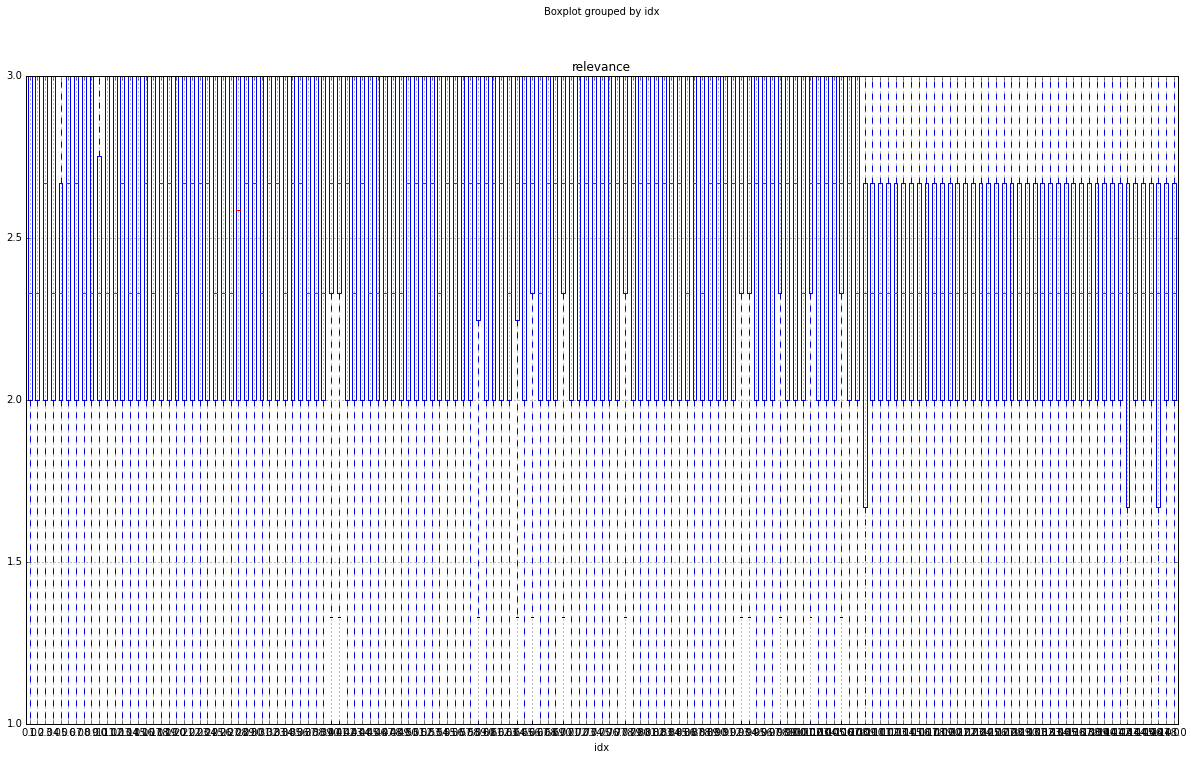

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

a.boxplot(by='idx', column='relevance')
#plt.show()

In [79]:
a.loc[0:53749].mean(), a.loc[53749:].mean(), a.loc[0:53749].std(), a.loc[53749:].std(), a.loc[0:37033].mean(),  a.loc[0:37033].std()

(index        26874.500000
 id           82154.797079
 relevance        2.438043
 idx             53.251163
 dtype: float64, index         63907.500000
 id           192362.194852
 relevance         2.232436
 idx             127.314352
 dtype: float64, index        15516.432821
 id           46989.295530
 relevance        0.528320
 idx             31.033537
 dtype: float64, index         5865.445720
 id           16859.942498
 relevance        0.519996
 idx             11.735169
 dtype: float64, index        18516.500000
 id           56925.120106
 relevance        2.430660
 idx             36.534428
 dtype: float64, index        10690.939271
 id           32621.994979
 relevance        0.529679
 idx             21.380677
 dtype: float64)

In [89]:
0.529679**2 + 2.430660**2 - 2*2.430660 + 1

2.3273478786410005

In [84]:
1.16713**2  #1.52556

0.3621924369

In [90]:
math.sqrt(2* (1.16713**2 - 2.3273478786410005*0.5 ))

0.6301087169362122

In [62]:
m1 = 2.438043
m2 = 2.232436
s1 = 0.528320
s2 = 0.519996

In [67]:
f1 = s1**2 + m1**2 - 2*m1
f2 = s2**2 + m2**2 - 2*m2

In [74]:
math.sqrt(s1**2 + m1**2 - 2*m1 + 1)

1.5320214398790246

In [93]:
math.sqrt((f1+1)*0.5 + (0.44676**2) *0.5 )

1.128424607550057

In [98]:
72.5*0.3

21.75

In [97]:
math.sqrt(0.3*(0.44676**2) + 0.425*(f1+1) + 0.175*(f2+1))

1.1858768332494167

In [99]:
math.sqrt(0.3*(0.44676**2) + 0.425*0*(f1+1) + 0.275*0.3*(f2+1))

0.45551633543072856

In [ ]:
f1*a + f2*b = 1.1864945424000002, a + b = 1.0, f1 = 1.3470896922489999, f2 = 0.7892943341120002

In [71]:
a = 0.712
b = 0.288
a*0.30, b * 0.3

(0.21359999999999998, 0.08639999999999999)

In [ ]:
0.3*0.44676**2 + 0.425*(f1+1) + (x-0.725)*(f2+1) = 1.22863**2, f1 = 1.3470896922489999, f2 = 0.7892943341120002

In [72]:
72.5-21.4

51.1

In [73]:
51.1/21.4  * 8.6

20.535514018691593

In [76]:
#a.tail(), 
53749.0/74066, 74066*0.5

(0.72569060027543, 37033.0)

In [56]:
a.groupby('idx').mean().iloc[100:130]

,index,id,relevance
idx,,,
100.0,50249.5,152572.270,2.40806
101.0,50749.5,154128.044,2.51144
102.0,51249.5,155649.916,2.44490
103.0,51749.5,157167.134,2.44206
104.0,52249.5,158694.960,2.42346
105.0,52749.5,160137.088,2.49028
106.0,53249.5,161593.072,2.46404
107.0,53749.5,163104.032,2.42352
108.0,54249.5,164512.028,2.16418


In [23]:
b = a.sample(n=500).groupby('idx').mean()

In [32]:
%matplotlib inline

In [47]:
idx_train['relevance'].mean()

2.3816337910270433

In [54]:
idx_train['relevance'].std()  + idx_train['relevance'].mean() ** 2 - 2 *idx_train['relevance'].mean()  +1 

2.4428958809249632

In [3]:
idx_train

,relevance
id,
2,3.00
3,2.50
9,3.00
16,2.33
17,2.67
18,3.00
20,2.67
21,3.00
23,2.67


In [4]:
240760*0.13

31298.8

In [5]:
240760-221473

19287

In [6]:
# never tried this
fo1 = pd.read_csv('/Users/rbekbolatov/Downloads/Aug25_test_0.csv', encoding="ISO-8859-1")
fo1.columns = ['id', 'rel1']
fo2 = pd.read_csv('/Users/rbekbolatov/Downloads/combined_res6.csv', encoding="ISO-8859-1")
fo2.columns = ['id', 'rel2']

res = pd.merge(fo1, fo2, how='left', on='id')

def f(r):
    return r['rel1']*0.55 + r['rel2']*0.45

y_pred = res.apply(f, axis=1)
pd.DataFrame({"Id": res['id'], "Hazard": y_pred}).to_csv('COMB_TOP_2.csv',index=False)

In [4]:
fo1 = pd.read_csv('/Users/rbekbolatov/Downloads/Aug25_test_0.csv', encoding="ISO-8859-1")
fo1.head()

,Id,Hazard
0,6,0.305536
1,7,0.452281
2,8,0.524052
3,9,0.348421
4,10,0.311800
